In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!cd /content/drive/MyDrive

# Extract All File From Zip

In [3]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/Cat vs Dog/dogs-vs-cats.zip','r') as zipobj:
  #Extract all the content from zip file in the current directory
  zipobj.extractall()

with ZipFile('train.zip','r') as zipobj:
  #Extract all the content from zip file in the current directory
  zipobj.extractall()

with ZipFile('test1.zip','r') as zipobj:
  #Extract all the content from zip file in the current directory
  zipobj.extractall()

# **Create sub directory so the data is in formate**



---train

1.   dogs
2.   cats


--- test


1.   dogs
2.   cats









In [4]:
from os import makedirs
# Create directories
dataset_name = 'dataset_dog_vs_cat/'
subdirs = ['train/', 'test/']

for subdir in subdirs:
  #create label subdirectories
  labeldirs = ['dogs/', 'cats/']
  for labeldir in labeldirs:
    newdir = dataset_name + subdir + labeldir
    makedirs(newdir, exist_ok = True)

#  Now Change Your Dataset In to This Format

In [5]:
from os import listdir
from shutil import copyfile
#create directories
from random  import seed, random
seed(1)

#define ration of picture to use for validation
val_ratio = 0.25
# Copy training dataset images into subdirectories
src_directory = 'train'
dataset_home = 'dataset_dog_vs_cat/'
for file in listdir(src_directory):
  src = src_directory + '/'+ file
  dst_dir = 'train/'
  if random() <val_ratio:
    dst_dir = 'test/'
  if file.startswith('cat'):
    dst = dataset_home + dst_dir + 'cats/' + file
    copyfile(src, dst)
  elif file.startswith('dog'):
    dst = dataset_home + dst_dir + 'dogs/' + file
    copyfile(src, dst)

# Prepare a model for transfer learning

In [6]:
# loading model libary
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# ready model for transfer learning
model = VGG16(include_top = False, input_shape =(224, 224, 3))

# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False

#add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation = 'relu', kernel_initializer= 'he_uniform')(flat1)
output = Dense(1, activation='sigmoid')(class1)

#define model
model = Model(inputs = model.inputs, outputs = output)

#compile model
opt = SGD(learning_rate = 0.001, momentum = 0.9)
model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics= ['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


# Run the Model Using Generator

In [7]:
datagen = ImageDataGenerator(featurewise_center = True)
# specify imagenet mean values for centering
datagen_mean = [123.68, 116.779, 103.939]

#prepare iterator
train_it = datagen.flow_from_directory('dataset_dog_vs_cat/train/',
          class_mode = 'binary',batch_size = 64, target_size = (224,224))

test_it = datagen.flow_from_directory('dataset_dog_vs_cat/test/',
          class_mode = 'binary',batch_size = 64, target_size = (224,224))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


## Fit The **Model**

In [8]:
history = model.fit_generator(train_it, steps_per_epoch = len(train_it),
        validation_data= test_it, validation_steps = len(test_it), epochs=5, verbose=1)

<ipython-input-8-0a678adbfc75>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch = len(train_it),
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/5
293/293 [==============================] - 225s 713ms/step - loss: 0.2251 - accuracy: 0.9556 - val_loss: 0.0764 - val_accuracy: 0.9703
Epoch 2/5
293/293 [==============================] - 154s 526ms/step - loss: 0.0371 - accuracy: 0.9866 - val_loss: 0.0827 - val_accuracy: 0.9687
Epoch 3/5
293/293 [==============================] - 155s 529ms/step - loss: 0.0105 - accuracy: 0.9970 - val_loss: 0.0969 - val_accuracy: 0.9727
Epoch 4/5
293/293 [==============================] - 137s 468ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.1110 - val_accuracy: 0.9737
Epoch 5/5
293/293 [==============================] - 128s 437ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.1164 - val_accuracy: 0.9732


# Plot The Loss and Accuracy

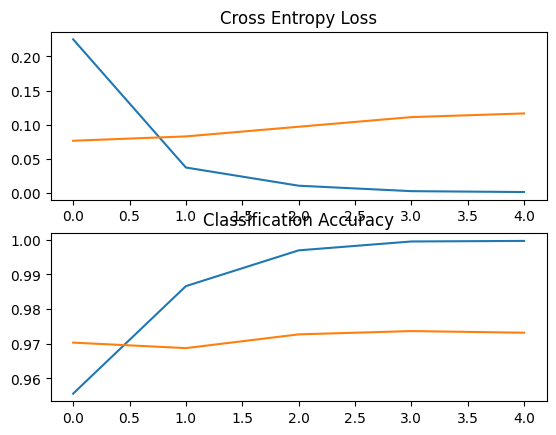

In [10]:
import matplotlib.pyplot as plt
import sys
plt.subplot(2,1,1)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')

#plot accuracy
plt.subplot(2,1,2)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.show()

# Save the model for future use

In [11]:
model.save('dog_vs_cat_model.h5')

# Predict By Model

In [15]:
# from keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from keras.models import load_model

#load and prepare the image
#load the image
img = load_img('/content/dataset_dog_vs_cat/test/dogs/dog.10006.jpg',target_size=(224,224))
#convert to array
img = img_to_array(img)

#load_model
model = load_model('/content/dog_vs_cat_model.h5')
#reshape to array
img = img.reshape(1,224,224,3)

#center pixel data
img = img.astype('float32')

img = img- [123.68, 116.779, 103.939]

In [18]:
# 1 for dogs and 0 for cats
result = model.predict(img)
print(result[0])

1/1 [==============================] - 0s 27ms/step
[1.]
